In [1]:
import os
import sys
from time import time

import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

import mlflow
from mlflow.tracking import MlflowClient

import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

## Load Features

Carrega as features extraídas com o modelo VGG16, que consistem em um vetor de dimensão 4096 para cada uma das 10071 imagens.

In [3]:
objects = []
with (open("../extracao/vgg16.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pkl.load(openfile))
        except EOFError:
            break


In [8]:
X = pd.DataFrame([o[1] for o in objects])

In [8]:
X

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.000000,0.000000,0.000000,0.000000,0.563937,0.000000,0.000000,1.833766,0.000000,1.962956,...,0.793387,0.0,2.697644,0.000000,0.000000,0.000000,6.665195,0.489006,0.000000,0.000000
1,1.234399,0.865545,1.106845,0.000000,3.255290,1.038765,0.000000,0.000000,0.000000,0.000000,...,0.212706,0.0,0.000000,0.000000,0.742095,0.000000,4.835922,0.000000,2.766514,0.000000
2,3.036267,0.000000,0.000000,0.000000,3.894413,3.429538,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,4.503814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.029929,0.000000,0.000000,0.000000,1.533260,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.279605,0.000000,1.940058,0.000000,0.000000,0.000000,0.000000,4.615903
4,0.000000,0.000000,0.000000,0.132773,0.000000,0.580434,0.000000,0.000000,0.000000,0.000000,...,5.126976,0.0,4.368205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10068,0.000000,0.024616,4.775819,0.000000,3.782488,0.000000,7.282493,0.000000,0.000000,0.153982,...,2.046525,0.0,0.000000,0.558607,1.120000,0.000000,0.000000,0.070311,0.818325,0.000000
10069,0.000000,0.000000,3.098676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.009502,...,0.000000,0.0,0.000000,2.692736,0.000000,0.000000,0.000000,4.326555,0.000000,0.000000
10070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.407976,0.000000,...,0.000000,0.0,0.000000,1.127304,4.614251,0.000000,0.000000,0.000000,0.000000,0.905138
10071,0.000000,0.000000,0.000000,0.000000,0.000000,4.312284,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.471498,0.000000


In [9]:
y = pd.DataFrame([o[2] for o in objects])

In [10]:
r_state = 10


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=r_state
)


In [14]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

## Redução de Dimensionalidade

Reduz as dimensões dos vetores de características de 4096 para 300. Este valor foi obtido experimentalmente. O método utilizado foi a análise de componentes principais.

In [15]:
pca = PCA(n_components=300)

In [16]:
pca.fit(X_train)

PCA(n_components=300)

In [26]:
X_train = pca.transform(X_train)

## Regressão

Utiliza a regressão linear do sklearn.

In [27]:
model= LinearRegression()

In [162]:
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

## Validação

Abaixo, segue o desempenho do modelo no conjunto de treino e de teste. Depois, é apresentado o gráfico de dispersão do previsto versus observado.

In [29]:
y_pred_test = model.predict(pca.transform(X_test))
rmse, mae, r2 = eval_metrics(y_test, y_pred_test)
print (f"Desempenho no conjunto de Testes (Validação)\nrmse:{rmse}    mae:{mae}    r2:{r2}")

y_pred_train = model.predict(X_train)
rmse, mae, r2 = eval_metrics(y_train, y_pred_train)
print (f"Desempenho no conjunto de Treino\nrmse:{rmse}    mae:{mae}    r2:{r2}")



Desempenho no conjunto de Testes (Validação)
rmse:10.75421041299279    mae:8.365044502786231    r2:0.5117887583887726
Desempenho no conjunto de Treino
rmse:10.359857569758116    mae:8.070606588739164    r2:0.5501548595642243


array([71.19432 , 58.600037, 51.276676, ..., 64.8631  , 68.628845,
       60.520573], dtype=float32)

In [37]:
#Preparação para o gráfico
y_pred_test = y_pred_test.flatten()
y_test = y_test.values.flatten()
predicted_actual = {
    "True values": y_test, "Predicted valuesLR": y_pred_test}
predicted_actual = pd.DataFrame(predicted_actual)
predicted_actual

,True values,Predicted valuesLR
0,57.841743,71.194321
1,57.228155,58.600037
2,30.796117,51.276676
3,58.957983,67.351074
4,64.675000,63.429527
...,...,...
3017,64.027027,57.348686
3018,62.641509,63.109566
3019,60.608108,64.863098
3020,67.308411,68.628845


In [ ]:
sns.scatterplot(data=predicted_actual,
                x="Predicted valuesGB", y="Predicted valuesLR",hue="True values",
                palette="rocket", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
#plt.legend([],[], frameon=False)
_ = plt.title("Linear Regression Model\nPrediction vs Observed")

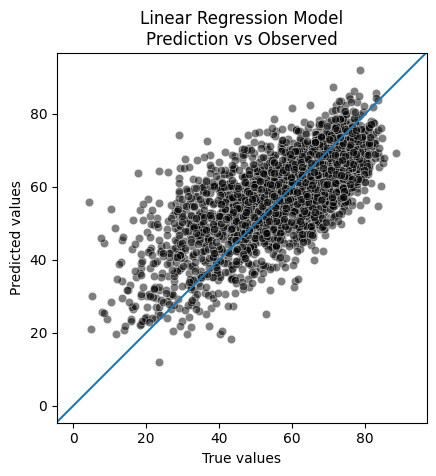

In [45]:
predicted_actual = {
        "True values": y_test.flatten(), "Predicted values": model.predict(pca.transform(X_test)).flatten()}
predicted_actual = pd.DataFrame(predicted_actual)



sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
_ = plt.title("Linear Regression Model\nPrediction vs Observed")

## Registro

In [17]:
def connectMLFlow(MLFlowAddr):
    client = MlflowClient(tracking_uri=MLFlowAddr)
    mlflow.set_tracking_uri(MLFlowAddr)
    return client

In [18]:
client = connectMLFlow("http://172.27.0.1:5000")

In [ ]:
experiment_name = "VGG16 Model"
try:
    experiment_id = client.create_experiment(experiment_name)
except:
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id
    
experiment = mlflow.set_experiment(experiment_name)
run_name = "PCA"

In [53]:
start = time()
with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id

    mlflow.sklearn.log_model(pca,"model/")
    mlflow.end_run()
end = time()
run_time = end - start

print ("Tempo para rodar essa célula: {}m {:.3f}s".format(int(run_time/60), run_time%60))

Tempo para rodar essa célula: 0m 25.959s
